In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity= 'all'
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
sn.set()
import matplotlib.font_manager as fm
fl = fm.FontProperties(fname ="C:\Windows\Fonts\malgun.ttf").get_name()
plt.rc('font',family=fl)
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

# 데이터 주도 학습

- 규칙을 사람이 만드는 방식에서 기계가 데이터로부터 배우는 방식으로의 패러다임 전환
- 딥러닝을 종단간 기계학습(end-to-end-machine learning)이라고 함
- 범용 능력을 제대로 평가하기 위해 훈련데이터와 시험데이터를 분리(8:2)
- 한 데이터셋에만 지나치게 최적화된 상태를 오버피팅(overfitting)이라고 함

===========================================================================

# 손실함수

- 실제 값과 예측 값과의 차이를 이용한 함수로 평균제곱오차(RMSE)와 교차 엔트로피(cross-entropy) 오차를 주로 사용

## Mean Square Error(MSE)
$$E=\frac{1}{2}\sigma_k(y_k-t_k)^2$$
$y_k$: 신경망의 출력, $t_k$: 정답 레이블, $k$: 데이터의 차원 수

한 원소만 1로 하고 그 외는 0으로 나타내는 표기법은 원-핫 인코딩이라고 함

In [2]:
y = [0.1, 0.2, 0.6, 1.2, 1.3, 1.1, 0.8, 0.9]
t = [0, 0, 0, 1, 0, 0, 0, 0,]
def MSE(y, t):
    return 0.5*np.sum((y-t)**2) # 이렇게 하면 같은 위치만 계산하니까

MSE(np.array(y), np.array(t))

2.4000000000000004

### 교차 엔트로피 오차 

$$E =-\Sigma_k t_k long y_k$$

In [3]:
def cross_entropy_error(y,t):
    delta=1e-7 # 10의 -7제곱
    return -np.sum(t*np.log(y+delta)) # -가 무한으로 가지 않게 방지
cross_entropy_error(np.array(y), np.array(t))

-0.1823216401272845

## 미니배치 학습 

- 교차 엔트로피의 경우
$$E =-\frac{1}{N}\Sigma_n\Sigma_k t_k long y_{nk}$$
데이터가 N개라면 $t_{nk}$는 $n$번째 데이터의 k번째 값을 의미
- 마지막에 N을 나눠 줌으로써 평균 손실 함수 값을 구함
- 이 일부를 미니배치라고 하고 무작위로 일부를 추출해 학습하는 것을 미니배치 학습이라고 함.

```python
np.random.choice(60000, 10)
```

In [4]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize =True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

ModuleNotFoundError: No module named 'mnist'

In [ ]:
print(x_train.shape[0])

In [ ]:
# 무작위로 10개 뽑기

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [ ]:
print(x_batch.shape)

In [ ]:
print(batch_mask)

In [ ]:
np.random.choice(500, 10)

In [ ]:
# 배치용 교차 엔트로피 에러

def cross_entropy_error(y,t):
    if y.ndim == 1:
        t=t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    # one-hot-vector 인 경우
    if t.size == y.size:
        t= t.argmax(axis = 1)
        
        
    batch_size = y.shape[0];
    return -np.sum(np.log(y[np.arange(batch_size),t] +1e-7))/batch_size

## 수치미분

- 경사법에서는 기울기 값을 기준으로 나아갈 방향을 정함
- 수치미분 : 아주 작은 차분으로 미분하는 것
    - 편미분(partial derivative)
    - gradient : 함수의모든 변수의 편미분을 벡터로 정리한 것

In [ ]:
import matplotlib.pylab as plt
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h) # (수치)미분

def function_1(x):
    return 0.01*x**2 + 0.1*x

# x에서 d방향으로 변햇을 때 얼마나 바뀌었는지
def tangent_line(f,x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y 

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

<Figure size 432x288 with 0 Axes>

(-2, 2)

(-2, 2)

Text(0.5, 0, 'x0')

Text(0, 0.5, 'x1')

C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


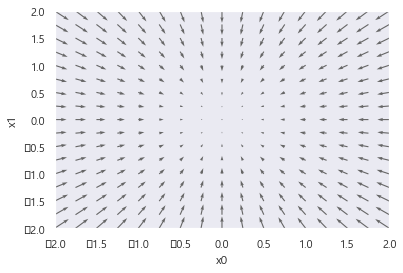

In [5]:
# coding: utf-8
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

# 중요 1
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val 
        
    return grad

# 중요 2
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis = 1)
    
def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t : d*t + y
    
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y =np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X,Y]).T).T
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1], angles = 'xy', color = '#666666')
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()
    
# (0,0)이 가장 낮은 구모양의 형태 경사하강

## 경사법(경사 하강법, gradinet descent method)

- 기울기를 이용해 함수의 최솟값 (또는 가능한한 작은 값)을 찾으려는 것
- 각 지점에서 함수의 값을 낮추는 방안을 제시하는 지표가 기울기가 가리키는 곳에 함수의 최솟값이 있는 것은 아님(안장점)
- 하지만, 적어도 그 방향으로 가야만 함수의 값을 줄일 수 있음.

$$x_0=x_0-\eta \frac{\partial f}{\partial x_0}$$
$$x_1=x_1-\eta \frac{\partial f}{\partial x_1}$$
$\eta$: 학습률(learning rate)

- 위 단계를 반복해서 시행
- 학습률이 너무 크면 큰 값으로 발산하고 너무 작으면 갱신디 되지 않는 문제가 발생

In [6]:
def gradient_descent(f, init_x, lr, step_num): # lr을 learning rate
    x=init_x
    x_history=[]
    
    for i in range(step_num):
        x_history.append(x.copy())
        grad = _numerical_gradient_no_batch(f, x)
        x -= lr*grad # 이게 아주 중요
        
    return x, np.array(x_history) # 들여쓰기 주의
    
def function_2(x):
    return x[0]**2 + x[1]**2


In [7]:
print(x_history)

NameError: name 'x_history' is not defined

Text(0.5, 0, 'X0')

Text(0, 0.5, 'Y1')

C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Hyobin An\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


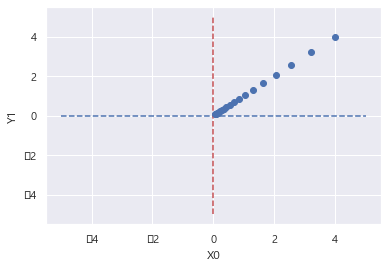

In [8]:
init_x=np.array([4.0,4.0])
lr = 0.1 # 숫자가 작을수록 천천히가고 클수록 빨리감 (하이퍼 파라미터)
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=0.1, step_num=step_num)
plt.plot([-5,5],[0,0], '--b')
plt.plot([0,0],[-5,5], '--r')
plt.plot(x_history[:,0], x_history[:, 1], 'o')
plt.xlabel('X0')
plt.ylabel('Y1')
plt.show()

## 신경망에서의 기울기

- 가중치 매개변수에 대한 손실함수의 기울기를 의미
- 예를 들어 혀앙이 $2\times3$, 가중치가 $W$, 손실함수가 $L$인 신경망의 경우 경사는 $\frac{\partial L}{\partial W}$로 표현
- $\frac{\partial L}{\partial W}$의 형상은 $W$와 같음 (편미분)

In [9]:
# Simple Net
# input : 2-d, output : 3-d

from functions import softmax, cross_entropy_error
from gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 가중치 정규분포 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y,t)
        
        return loss
    
x = np.array([0.6, 0.9])
t = np.array([0,0,1])

net = simpleNet()

f = lambda w: net.loss(x, t) # w를 매개변수로 하는 loss함수
dW = numerical_gradient(f, net.W)

print(net.W)
print(dW)

ModuleNotFoundError: No module named 'functions'

## 학습 알고리즘 구현

- 신경망의 절차

1) 미니배치 : 훈련 데이터 중 일부를 무작위로 가져와서 선별된 데이터 셋인 미니배치의 손실 함수를 줄이기 위한 목표 설정
2) 기울기 산출 : 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구함
3) 매개변수 갱신 : 가중치 매개벼수를 기울기 방향으로 아주 조금 갱신
4) 1~3 단계를 반복
-- 데이터를 미니배치로 무작위로 선정하기 때문에 이름 **확률적 경사 하강법(Stochastic gradient descent, SGD)**이라 부름

In [10]:
# 2층 신경망 클래스 구현하기

from functions import *
from gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {} #dictionary 로 정의 하는게 좋음
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        W1, W2 = self.params['W1'],self.params['W2']
        b1, b2 = self.params['b1'],self.params['b2']
        
        a1= np.dot(x, W1)+b1
        z1 = sigmoid(a1)
        a2=np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1 )
        t = np.argmax(t, axis = 1 )
        
        accuray = np.sum(y == t ) / float(x.shape[0])
        return accuracy # 정답률
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x,t) # loss(W) 함수의 정의
        grads={} # dictionary 로 정의
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

ModuleNotFoundError: No module named 'functions'

In [11]:
net = TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)

NameError: name 'TwoLayerNet' is not defined

In [12]:
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

NameError: name 'net' is not defined

In [13]:
x = np.random.rand(100, 784) # 784개 크기가 되는 100개 뽑기
y = net.predict(x)

NameError: name 'net' is not defined

In [14]:
print(x.shape)

(100, 784)


In [15]:
print(y)

[0.1, 0.2, 0.6, 1.2, 1.3, 1.1, 0.8, 0.9]


In [16]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grade = net. numerical_gradient(x,t)

NameError: name 'net' is not defined

In [39]:
grade['W1'].shape

(784, 100)

In [40]:
print(grade['W1'])

[[-6.51219789e-05  8.49495096e-05 -1.47303358e-04 ...  1.32152738e-04
   4.34234708e-04 -1.08182576e-04]
 [-7.80059506e-05  1.44659076e-04 -3.09907122e-05 ...  5.95531779e-05
   2.95138249e-04 -1.38302347e-04]
 [ 1.11573317e-04  3.05329175e-04 -1.32746609e-04 ...  1.36295053e-04
   4.99141628e-04 -3.56198093e-05]
 ...
 [-1.42350782e-04  1.62887765e-04 -1.52937900e-04 ...  2.08299933e-05
   2.98885903e-04  3.87939214e-05]
 [-1.27849900e-04  1.40386744e-04 -1.49675217e-04 ...  4.60420657e-05
   2.13624232e-04  8.11160139e-05]
 [-2.25089578e-04  1.52481123e-04 -8.22999113e-05 ...  3.09833958e-05
   2.33033681e-04 -1.73237424e-06]]


## 미니배치가 계산이 1시간 돌려도 계속 진행됩니다.

In [50]:
# 미니배치 학습 구현
import numpy as np

(x_train, t_train), (x_test, t_test) = load_mnist(normalize =True, one_hot_label=True)

train_loss_list = []

# hyperparameter 
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network=TwoLayerNet(input_size = 784, hidden_size = 100, output_size = 10)

for i in range(iters_num):
    #미니배치 흭득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'W2', 'b1','b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

KeyboardInterrupt: 